In [1]:
# Indicar si se montará el drive para colab
drive = True

In [2]:
if drive:
  from google.colab import drive
  drive.mount('/content/drive/')
  path = '/content/drive/Shareddrives/ML/Taller_2'
else:
  # especificar path a los datasets
  path = ''


Mounted at /content/drive/


In [3]:
# El notebook está hecho de tal forma que al ejecutar las celdas con training = True se entrenará el modelo
# Luego, sin reiniciar el entorno se debe cambiar a training = False y ejecutar toads las celdas inferiores para realizar las predicciones
training = True

# Imports

In [4]:
!pip install twython

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer # para transformar palabrasa a su raiz
from nltk.stem import WordNetLemmatizer #


from scipy import stats

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [6]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

# Import data


In [7]:
if training:
  travel_data = pd.read_csv(f'{path}/travel_packages_train.csv')
  print('Loaded: travel_packages_train')
else:
  travel_data = pd.read_csv(f'{path}/travel_packages_test.csv')
  print('Loaded: travel_packages_test')

travel_data = travel_data.rename(columns = {'Unnamed: 0': 'id'}, inplace = False)
travel_data.head(3)

Loaded: travel_packages_train


,id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules,PPPrice
0,7919,North East - Gangtok and Lachung,Deluxe,Gangtok|Lachung|Gangtok,1N Gangtok . 2N Lachung . 1N Gangtok,Gangtok|Lachung|Gangtok,10-01-2022,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,Spicejet|Spicejet,1,3,Singhik View Point | Chungthang | Yumthang Va...,Cancellation any time after making the 1st pay...,284.0
1,982,Spiritual Haridwar from Delhi,Budget,Haridwar,2N Haridwar,Haridwar,21-11-2021,Not Available,Mumbai,Not Available,2,2,Har Ki Pauri,Cancellation any time after making the 1st pay...,129.0
2,3211,Rajasthan Adventure Special with Guided Leopar...,Premium,Jodhpur|Jaisalmer,2N Jodhpur . 2N Jaisalmer,Jodhpur|Jaisalmer,06-08-2021,Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...,New Delhi,IndiGo,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,Cancellation any time after making the 1st pay...,311.0


In [9]:
if training:
  y = travel_data['PPPrice']
  data = travel_data.drop(columns=['PPPrice'])
  print(y.shape)
  print(data.shape)
else:
  data = travel_data

(15750,)
(15750, 14)


# Data

In [10]:
data.head(3)

,id,Package Name,Package Type,Destination,Itinerary,Places Covered,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered,Cancellation Rules
0,7919,North East - Gangtok and Lachung,Deluxe,Gangtok|Lachung|Gangtok,1N Gangtok . 2N Lachung . 1N Gangtok,Gangtok|Lachung|Gangtok,10-01-2022,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,Spicejet|Spicejet,1,3,Singhik View Point | Chungthang | Yumthang Va...,Cancellation any time after making the 1st pay...
1,982,Spiritual Haridwar from Delhi,Budget,Haridwar,2N Haridwar,Haridwar,21-11-2021,Not Available,Mumbai,Not Available,2,2,Har Ki Pauri,Cancellation any time after making the 1st pay...
2,3211,Rajasthan Adventure Special with Guided Leopar...,Premium,Jodhpur|Jaisalmer,2N Jodhpur . 2N Jaisalmer,Jodhpur|Jaisalmer,06-08-2021,Indana Palace Jodhpur:4.3|Jaisalmer Marriott R...,New Delhi,IndiGo,0,5,Hanwant Mahal | Candlelight Dinner in Jodhpur...,Cancellation any time after making the 1st pay...


In [11]:
data.isnull().sum()

id                            0
Package Name                  0
Package Type                  0
Destination                   0
Itinerary                     0
Places Covered                0
Travel Date                   0
Hotel Details                 0
Start City                    0
Airline                       0
Flight Stops                  0
Meals                         0
Sightseeing Places Covered    0
Cancellation Rules            0
dtype: int64

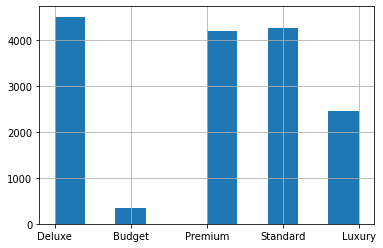

In [12]:
data['Package Type'].hist()

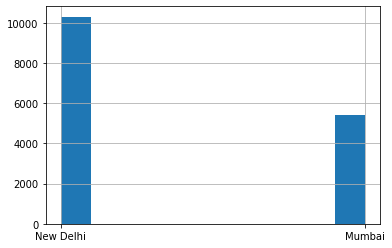

In [13]:
data['Start City'].hist()

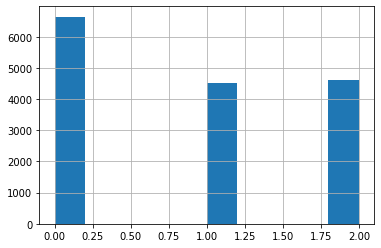

In [14]:
data['Flight Stops'].hist()

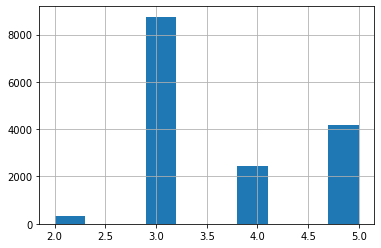

In [15]:
data['Meals'].hist()

In [16]:
data.stack().value_counts()

Cancellation any time after making the 1st payment instalment till the 2nd payment date:The entire amount paid as 1st payment instalment (deposit) would be non-refundable.Cancellation after 2nd payment instalment and before 3rd or final payment date:The total amount that was due at the 2nd payment instalment as per your payment schedule would be non-refundable; anything that you have paid over and above this amount would be refundable.Cancellation after 3rd or final payment date:The full amount paid by you would be non-refundable.    13198
New Delhi                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [17]:
data['Destination'].equals(data['Places Covered'])

True

In [18]:
airline = data['Airline']

In [19]:
uniq_airline = set()
len_airlines = set()

In [20]:
def filter_airline(x):
  air = x.split('|')
  len_airlines.add(len(air))
  for elem in air:
    uniq_airline.add(elem)
  return x

In [21]:
airline = airline.apply(filter_airline)
airline.head(5)

0    Spicejet|Spicejet
1        Not Available
2               IndiGo
3        Not Available
4               Go Air
Name: Airline, dtype: object

In [22]:
print(f'Cantidad de aerolineas: {len(uniq_airline)}\nCantidades de vuelos: {len(len_airlines)}')

Cantidad de aerolineas: 56
Cantidades de vuelos: 11


# Preprocessing

In [23]:
# Drop Places Covered ya que es igual a Destination
data = data.drop(columns=['Places Covered', 'Destination', 'Cancellation Rules'])
data.head(1)

,id,Package Name,Package Type,Itinerary,Travel Date,Hotel Details,Start City,Airline,Flight Stops,Meals,Sightseeing Places Covered
0,7919,North East - Gangtok and Lachung,Deluxe,1N Gangtok . 2N Lachung . 1N Gangtok,10-01-2022,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,New Delhi,Spicejet|Spicejet,1,3,Singhik View Point | Chungthang | Yumthang Va...


## Categorical Variables

In [24]:
cat = data[['Package Type', 'Travel Date', 'Start City', 'Flight Stops', 'Meals']]
print(cat.shape)
cat.head(1)

(15750, 5)


,Package Type,Travel Date,Start City,Flight Stops,Meals
0,Deluxe,10-01-2022,New Delhi,1,3


### Encode Package Type

In [25]:
categories = list(set(cat['Package Type']))
categories

['Luxury', 'Budget', 'Premium', 'Standard', 'Deluxe']

In [26]:
encoder = lambda x : categories.index(x)

In [27]:
encoded_cat = cat['Package Type'].apply(encoder)
encoded_cat

0        4
1        1
2        2
3        2
4        4
        ..
15745    4
15746    3
15747    0
15748    3
15749    4
Name: Package Type, Length: 15750, dtype: int64

In [28]:
cat = cat.drop(columns=['Package Type'])
cat.head(1)

,Travel Date,Start City,Flight Stops,Meals
0,10-01-2022,New Delhi,1,3


In [29]:
cat['Package Type'] = encoded_cat
cat.head(1)

,Travel Date,Start City,Flight Stops,Meals,Package Type
0,10-01-2022,New Delhi,1,3,4


### Convert Date to Day of Year

In [30]:
date_conv = lambda x : datetime.strptime(x,'%d-%m-%Y').timetuple().tm_yday

In [31]:
cat['Travel Date'] = cat['Travel Date'].apply(date_conv)
cat.head(1)

,Travel Date,Start City,Flight Stops,Meals,Package Type
0,10,New Delhi,1,3,4


### Start City

In [32]:
cities = list(set(cat['Start City']))
encode_city = lambda x: cities.index(x)+1

In [33]:
cat['Start City'] = cat['Start City'].apply(encode_city)
print(cat.shape)
cat.head(3)

(15750, 5)


,Travel Date,Start City,Flight Stops,Meals,Package Type
0,10,2,1,3,4
1,325,1,2,2,1
2,218,2,0,5,2


## Text Variables

In [34]:
text = data[['Package Name', 'Itinerary', 'Hotel Details', 'Airline', 'Sightseeing Places Covered']]
# text = data[['Itinerary', 'Hotel Details', 'Airline']]
text.head(1)

,Package Name,Itinerary,Hotel Details,Airline,Sightseeing Places Covered
0,North East - Gangtok and Lachung,1N Gangtok . 2N Lachung . 1N Gangtok,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,Spicejet|Spicejet,Singhik View Point | Chungthang | Yumthang Va...


### Create just one column with the Package data

In [35]:
cols = list(text.columns)
cols

['Package Name',
 'Itinerary',
 'Hotel Details',
 'Airline',
 'Sightseeing Places Covered']

In [36]:
text['Package'] = text[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
text.head(1)

,Package Name,Itinerary,Hotel Details,Airline,Sightseeing Places Covered,Package
0,North East - Gangtok and Lachung,1N Gangtok . 2N Lachung . 1N Gangtok,Summit Denzong Hotel & Spa:4.5|Summit Alpine R...,Spicejet|Spicejet,Singhik View Point | Chungthang | Yumthang Va...,North East - Gangtok and Lachung 1N Gangtok . ...


In [38]:
text['Package'][0]

'North East - Gangtok and Lachung 1N Gangtok . 2N Lachung . 1N Gangtok Summit Denzong Hotel & Spa:4.5|Summit Alpine Resort:5.0|Lemon Tree Hotel  Gangtok: Spicejet|Spicejet  Singhik View Point | Chungthang | Yumthang Valley | Hot Spring '

### TFIDF

In [39]:
tokenizer = TfidfVectorizer().build_tokenizer() #Return a function that splits a string into a sequence of tokens considering unicode characters
stemmer = SnowballStemmer("english") 
lemmatizer = WordNetLemmatizer()

In [40]:
remove_stops_here = False
words = set(nltk.corpus.words.words())
def my_pre_processer(text, debug = False):
    results = []
    if (debug):
        print("Tokenizer result: ", tokenizer(text))
    for token in tokenizer(text):
      if token in words:      
        clean_token = token.lower().strip('-').strip('_')
        if remove_stops_here and (clean_token in stopwords.words('english')):
          continue
        #token_pro = stemmer.stem(clean_token) #podemos probar stemming en vez de lematizacion
        token_pro = lemmatizer.lemmatize(clean_token) 
        if len(token_pro) > 2 and not token_pro[0].isdigit(): #elimina palabra largo menor a 2
            results.append(token_pro)
    return results

In [41]:
if training:
  ngram_max = 1
  max_features = 500
  min_df=1
  max_df = 0.8

  vectorizer = TfidfVectorizer(stop_words='english',tokenizer=my_pre_processer,min_df=min_df, max_df=max_df, max_features=max_features,
                                binary=False, use_idf=True, smooth_idf=True, norm=None, ngram_range=(1, ngram_max))

In [42]:
package = text['Package']
package.head(1)

0    North East - Gangtok and Lachung 1N Gangtok . ...
Name: Package, dtype: object

In [43]:
if training:
  vectorizer.fit(package)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


In [44]:
package_tfidf = vectorizer.transform(package)

In [45]:
package_tfidf.toarray().shape

(15750, 500)

In [46]:
text_data = pd.DataFrame(data=package_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
print(text_data.shape)
text_data.head(3)

(15750, 500)


,abbey,aboard,abu,added,adorable,adventure,air,airport,alpine,ama,amazing,amman,anthropological,aqua,art,aru,astonishing,atrium,available,avalanche,awesome,baba,backwater,baga,bali,balloon,ban,bangkok,bari,basis,bay,beach,bear,beautiful,beauty,best,bibi,bird,blair,blissful,...,trip,tulip,turtle,ultimate,unit,unwind,vacation,valley,value,vibrant,viceregal,view,viewpoint,villa,village,vintage,visit,vista,walk,walking,walnut,war,warmth,waterfall,week,weekend,western,white,wildlife,windflower,winter,wood,world,wow,yas,yoga,young,zone,zoo,zoological
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,4.509801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.663639,0.0,0.0,0.0,3.358128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.359565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,5.239709,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create X

In [47]:
cat.reset_index(drop=True, inplace=True)
text_data.reset_index(drop=True, inplace=True)
X = pd.concat([cat, text_data], axis = 1)

In [48]:
print(X.shape)
print(cat.shape)
print(text_data.shape)

(15750, 505)
(15750, 5)
(15750, 500)


In [49]:
X.head(1)

,Travel Date,Start City,Flight Stops,Meals,Package Type,abbey,aboard,abu,added,adorable,adventure,air,airport,alpine,ama,amazing,amman,anthropological,aqua,art,aru,astonishing,atrium,available,avalanche,awesome,baba,backwater,baga,bali,balloon,ban,bangkok,bari,basis,bay,beach,bear,beautiful,beauty,...,trip,tulip,turtle,ultimate,unit,unwind,vacation,valley,value,vibrant,viceregal,view,viewpoint,villa,village,vintage,visit,vista,walk,walking,walnut,war,warmth,waterfall,week,weekend,western,white,wildlife,windflower,winter,wood,world,wow,yas,yoga,young,zone,zoo,zoological
0,10,2,1,3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.509801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.663639,0.0,0.0,0.0,3.358128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
scaler = StandardScaler()
cols = X.columns
scaled = scaler.fit_transform(X)
X = pd.DataFrame(data = scaled, columns = cols)
X.head(1)

,Travel Date,Start City,Flight Stops,Meals,Package Type,abbey,aboard,abu,added,adorable,adventure,air,airport,alpine,ama,amazing,amman,anthropological,aqua,art,aru,astonishing,atrium,available,avalanche,awesome,baba,backwater,baga,bali,balloon,ban,bangkok,bari,basis,bay,beach,bear,beautiful,beauty,...,trip,tulip,turtle,ultimate,unit,unwind,vacation,valley,value,vibrant,viceregal,view,viewpoint,villa,village,vintage,visit,vista,walk,walking,walnut,war,warmth,waterfall,week,weekend,western,white,wildlife,windflower,winter,wood,world,wow,yas,yoga,young,zone,zoo,zoological
0,-1.856127,0.726288,0.155426,-0.744789,1.111536,-0.203907,-0.093328,-0.134417,-0.130818,-0.051709,-0.120657,-0.420089,-0.173115,5.70181,-0.063372,-0.097396,-0.110076,-0.089039,-0.058107,-0.146337,-0.082954,-0.053529,-0.050285,-0.60708,-0.045121,-0.118472,-0.266991,-0.074504,-0.076652,-0.134155,-0.043852,-0.059682,-0.098873,-0.169527,-0.113312,-0.116011,-0.289269,-0.139819,-0.136478,-0.091582,...,-0.276161,-0.052322,-0.124394,-0.095721,-0.197263,-0.06487,-0.209631,1.468898,-0.287953,-0.056997,-0.213399,2.598541,-0.102894,-0.157339,-0.247402,-0.184411,-0.171499,-0.062865,-0.166531,-0.053618,-0.081134,-0.182748,-0.076652,-0.210116,-0.155318,-0.199352,-0.198345,-0.067389,-0.216864,-0.124919,-0.06693,-0.054122,-0.068466,-0.073662,-0.041866,-0.067767,-0.062354,-0.045121,-0.311139,-0.237356


# Train Model

In [51]:
print(X.shape)
print(y.shape)

(15750, 505)
(15750,)


In [52]:
if training:
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(mean_absolute_percentage_error(y_test, y_pred))

0.16923409884634075


In [53]:
def write_to_csv(X, y, filename, path = False):
  try:
    y = pd.DataFrame(data=y, columns=['PPPrice'])
    df = pd.concat([X, y], axis = 1)
    df = df[['id', 'PPPrice']]
    df = df.rename(columns={"id": "Index"})
    if path:
      df.to_csv(f'{path}/{filename}')  
    else:
      df.to_csv(filename, index=False)
    return True
  except Exception as e:
    print(e)
    return False
  return

In [54]:
id = travel_data['id']
id.head(1)

0    7919
Name: id, dtype: int64

In [55]:
id.shape

(15750,)

In [56]:
if not training:
  y_pred = model.predict(X)
  print(write_to_csv(pd.concat([id, X], axis = 1), y_pred, 'result.csv'))